In [1]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx as nx
import time
import matplotlib.pyplot as plt
import pickle
import numpy as np
from seirsplus.utilities import load_model, save_model, convert_percentage_to_scale
# from seirsplus.networks import prune_graph_per_age
plt.rcParams["figure.figsize"] = (12, 6)
import pandas as pd
import os
from scipy.interpolate import interp1d
plt.style.use('../../images/presentation.mplstyle')


In [2]:
acc_data = pd.read_csv("../accumulated_data_for_sim.csv")

In [3]:
def get_percentage_people_per_age_group(people_per_age, ages):
    n_total = people_per_age.num_people.sum()
    percentage_per_age = {}
    for a in ages:
        n_people = people_per_age[(people_per_age.age>=a[0]) & (people_per_age.age<=a[1])].num_people.sum()
        percentage = 100 * n_people/n_total
        percentage_per_age[a] = percentage
    return percentage_per_age

In [4]:
vacc_data = pd.read_csv("../../israel_data/vaccination_data_for_simulation.csv")


In [5]:
def get_cmap(n=20, map_str= 'hsv'):
    cmap = plt.get_cmap(map_str)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    return colors

In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [7]:
folder = 'third_wave_simulation/'

In [8]:
people_per_age = pd.read_csv("../../israel_data/num_people_per_age.csv")

ages_str = ['0-9',  '10-19','20-29','30-39','40-49','50-59','60-69','70-79', '80-100']
ages_per = [(int(a.split('-')[0]), int(a.split('-')[1])) for a in ages_str]
ages_dist_dict = get_percentage_people_per_age_group(people_per_age, ages_per)
age_dist = np.array(list(ages_dist_dict.values()))/100

In [9]:
#     model_data = data['model'][i].numPositive
#     time_to_plot = data['model'][i].tseries
#     smooth_model = moving_average(model_data, np.ceil(data['model'][i].numPositive.shape[0] / 100).astype(int))
#     smooth_time = moving_average(time_to_plot, np.ceil(data['model'][i].numPositive.shape[0] / 100).astype(int))
#     time_scale = np.arange(3, smooth_time.max()-1)
#     f_model = interp1d(smooth_time, smooth_model)
#     model_out = f_model(time_scale)
#     ax.plot(time_to_plot, model_data, color=colors[i_color], label=f'model:{i}')
#     ax.plot(time_scale, model_out, color=colors[i_color])
# #     ax.plot(time[35:], acc_cases[35:] * N / 9200000, marker='*', color='k', linewidth=2)
# #     for t, e in zip(times_for_sim, event):
# #         ax.axvline(int(t), 0, 1, c='k')
# #         ax.text(int(t)+0.1, 0, str(e), rotation=90)
# #     ax.plot(time_scale, real_data, '-k', marker='.')
# #     ax.plot(data['model'][i].tseries, (data['model'][i].numR + data['model'][i].numQ_R), label="num recovered", marker='*', color='r')
# #     ax.plot(data['model'][i].tseries, (data['model'][i].numPositive), label="num positive", marker='.', color='g')
    
#     ax2.plot(data['model'][i].tseries, (data['model'][i].numR + data['model'][i].numQ_R) - (data['model'][i].numPositive), label=f'model:{i}', marker='.', color=colors[i_color])

    
# #     age_dist = np.array([0.197,0.181,0.135,0.123,0.121,0.084,0.081,0.050,0.028])
#     x_k = []
#     y_m = []
#     for num, key in enumerate(data['model'][i].nodeGroupData.keys()):
#         num_nodes = data['model'][i].nodeGroupData[key]['nodes'].size
#         per_pop = num_nodes/N
#         mean_age = np.mean(data['model'][i].nodeGroupData[key]['numPositive']/(data['model'][i].numPositive+1e-5))
#         x_k.append(key)
#         y_m.append((mean_age/per_pop).astype(float))
# #         print(f"age:{key}, per real:{age_dist[num]}, per sim:{per_pop}")
# #         y_m.append((mean_age/age_dist[num]).astype(float))
# #     ax1.scatter(x_k,y_m, color=colors[i], marker='x')
#     ax1.bar(x_k,y_m, color=colors[i_color], alpha=0.3)
# #     relevant_input.append(np.array(y_m))
#     data['relevant_data'].append(relevant_input)
#     i_color += 1
# ax.legend()
# ax2.legend()
# ax2.grid()

# relevant_keys.append('model_diff')
# relevant_keys.append('folder_num')
# ax1.grid()
# ax.grid()


In [182]:
with open(f"../../israel_data/impact_factor_dict.pickle", 'rb') as handle:
            real_factor_dict_input =  pickle.load(handle)
ages_impact_factor = [(int(a.split('-')[0]), int(a.split('-')[1])) for a in list(real_factor_dict_input.keys())]
ages_impact_factor.append((0, 8))
ages_impact_factor.append((9, 19))
ages_impact_factor.append((20, 29))
ages_impact_factor.append((30, 39))
ages_impact_factor.append((40, 49))
ages_impact_factor.append((50, 59))
ages_impact_factor.append((60, 69))
ages_impact_factor.append((70, 79))
ages_impact_factor.append((80, 100))
percentages_each_age = get_percentage_people_per_age_group(people_per_age, ages_impact_factor)
real_factor_dict = {'0-9': (real_factor_dict_input['0-2'] * percentages_each_age[(0, 2)] + 
                                real_factor_dict_input['3-5'] * percentages_each_age[(3, 5)] + 
                                real_factor_dict_input['6-8'] * percentages_each_age[(6, 8)])/ percentages_each_age[(0, 8)],  
'10-19': (real_factor_dict_input['9-11'] * percentages_each_age[(9, 11)] + 
                                real_factor_dict_input['12-14'] * percentages_each_age[(12, 14)] + 
                                real_factor_dict_input['15-17'] * percentages_each_age[(15, 17)] + 
                                real_factor_dict_input['18-20'] * percentages_each_age[(18, 20)])/ percentages_each_age[(9, 19)],  
'20-29': (real_factor_dict_input['20-24'] * percentages_each_age[(20, 24)] +  
       real_factor_dict_input['25-29'] * percentages_each_age[(25, 29)])/ percentages_each_age[(20, 29)],  
'30-39': (real_factor_dict_input['30-34'] * percentages_each_age[(30, 34)] +  
       real_factor_dict_input['35-39'] * percentages_each_age[(35, 39)])/ percentages_each_age[(30, 39)], 
'40-49': (real_factor_dict_input['40-44'] * percentages_each_age[(40, 44)] +  
       real_factor_dict_input['45-49'] * percentages_each_age[(45, 49)])/ percentages_each_age[(40, 49)],  
'50-59': (real_factor_dict_input['50-54'] * percentages_each_age[(50, 54)] +  
       real_factor_dict_input['55-59'] * percentages_each_age[(55, 59)])/ percentages_each_age[(50, 59)], 
'60-69': (real_factor_dict_input['60-64'] * percentages_each_age[(60, 64)] +  
       real_factor_dict_input['65-69'] * percentages_each_age[(65, 69)])/ percentages_each_age[(60, 69)],
'70-79': (real_factor_dict_input['70-74'] * percentages_each_age[(70, 74)] +  
       real_factor_dict_input['75-79'] * percentages_each_age[(75, 79)])/ percentages_each_age[(70, 79)], 
'80+': real_factor_dict_input['80-100']}

In [364]:
# N = 10000
i_color = 0
directory ='results_0p7_iso_sym_delayed_10_perday_200' +("/")+'2021_05_06'
files_name = os.listdir(directory)
colors = get_cmap(len(files_name))

times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
             '7-8 back to school', 'British variant', '3rd lockdown',
             'schools close', 'Most cases new mutations', 'Closed airport',
             'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
             'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

time = acc_data.weeks_from * 7 - 35*7
acc_cases = acc_data.accumulated_cases_country



#subfolders = [f.path for f in os.scandir("g_third_lockdown/test_coeffs") if f.is_dir()]
data = {'model': [], 'input_config': [], 'relevant_data': []}
relevant_keys = ['R0_factor',
                'q_global_adults', 'q_global_kids', 'percentage_edges_removed_vacc', 'seed']
mean_vacc_per_day = []
plt.figure()
# model_names = ['no_policy_old', 'no_policy', 'young_to_old', '', 'triangle'] #, 'triangle'] #, 'young_to_old', 'triangle']
all_models = ['no_policy', 'young_to_old', 'all_ages', 'old_to_young','triangle'] #, 'old_to_young', 'young_to_old', 'triangle']
models_to_plot = range(int(len(files_name)/2))
# fig, ax = plt.subplots(1, 1)
# fig1, ax1 = plt.subplots(1, 1)
# fig2, ax2 = plt.subplots(1, 1)
model_names = []
for i in range(len(all_models)):
    if os.path.isfile(f"{directory}/input_config_"+str(all_models[i]+".pickle")):
        config_name = "input_config_"+str(all_models[i])
        path_name_config = f"{directory}/{config_name}"

        model_name = "model_"+all_models[i]
        path_name_model = f"{directory}/{model_name}"

        with open(f"{path_name_config}.pickle", 'rb') as handle:
            config_load=  pickle.load(handle)


        with open(f"{path_name_model}.pickle", 'rb') as handle:
            model_load=  pickle.load(handle)
        model_names.append(f"{all_models[i]}_10_perday_200")
    
#     relevant_input = [config_load[k] for k in relevant_keys]
#     N = config_load['N']
    
        data['model'].append(model_load)
        data['input_config'].append(config_load)    
        mean_vacc_per_day.append(240)

<Figure size 1080x360 with 0 Axes>

In [365]:
# # N = 10000
# i_color = 0
# directory ='results_0p7_iso_sym_delayed_10_perday_240' +("/")+'2021_05_06'
# files_name = os.listdir(directory)
# colors = get_cmap(len(files_name))

# times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
# event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
#              '7-8 back to school', 'British variant', '3rd lockdown',
#              'schools close', 'Most cases new mutations', 'Closed airport',
#              'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
#              'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

# time = acc_data.weeks_from * 7 - 35*7
# acc_cases = acc_data.accumulated_cases_country



# #subfolders = [f.path for f in os.scandir("g_third_lockdown/test_coeffs") if f.is_dir()]
# plt.figure()
# # model_names = ['no_policy_old', 'no_policy', 'young_to_old', '', 'triangle'] #, 'triangle'] #, 'young_to_old', 'triangle']
# all_models = ['no_policy', 'young_to_old', 'all_ages', 'old_to_young','triangle'] #, 'old_to_young', 'young_to_old', 'triangle']
# models_to_plot = range(int(len(files_name)/2))
# # fig, ax = plt.subplots(1, 1)
# # fig1, ax1 = plt.subplots(1, 1)
# # fig2, ax2 = plt.subplots(1, 1)
# for i in range(len(all_models)):
#     if os.path.isfile(f"{directory}/input_config_"+str(all_models[i]+".pickle")):
#         config_name = "input_config_"+str(all_models[i])
#         path_name_config = f"{directory}/{config_name}"

#         model_name = "model_"+all_models[i]
#         path_name_model = f"{directory}/{model_name}"

#         with open(f"{path_name_config}.pickle", 'rb') as handle:
#             config_load=  pickle.load(handle)


#         with open(f"{path_name_model}.pickle", 'rb') as handle:
#             model_load=  pickle.load(handle)
#         model_names.append(f"{all_models[i]}_10_perday_200")
    
# #     relevant_input = [config_load[k] for k in relevant_keys]
# #     N = config_load['N']
    
#         data['model'].append(model_load)
#         data['input_config'].append(config_load)    
#         mean_vacc_per_day.append(240)
     


In [366]:
# N = 10000
i_color = 0
directory ='results_0p7_iso_sym_delayed_10' +("/")+'2021_05_04'
files_name = os.listdir(directory)
colors = get_cmap(len(files_name))

times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
             '7-8 back to school', 'British variant', '3rd lockdown',
             'schools close', 'Most cases new mutations', 'Closed airport',
             'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
             'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

time = acc_data.weeks_from * 7 - 35*7
acc_cases = acc_data.accumulated_cases_country



#subfolders = [f.path for f in os.scandir("g_third_lockdown/test_coeffs") if f.is_dir()]
plt.figure()
# model_names = ['no_policy_old', 'no_policy', 'young_to_old', '', 'triangle'] #, 'triangle'] #, 'young_to_old', 'triangle']
all_models = ['no_policy', 'young_to_old', 'all_ages', 'old_to_young','triangle'] #, 'old_to_young', 'young_to_old', 'triangle']
models_to_plot = range(int(len(files_name)/2))
# fig, ax = plt.subplots(1, 1)
# fig1, ax1 = plt.subplots(1, 1)
# fig2, ax2 = plt.subplots(1, 1)
for i in range(len(all_models)):
    if os.path.isfile(f"{directory}/input_config_"+str(all_models[i]+".pickle")):
        config_name = "input_config_"+str(all_models[i])
        path_name_config = f"{directory}/{config_name}"

        model_name = "model_"+all_models[i]
        path_name_model = f"{directory}/{model_name}"

        with open(f"{path_name_config}.pickle", 'rb') as handle:
            config_load=  pickle.load(handle)


        with open(f"{path_name_model}.pickle", 'rb') as handle:
            model_load=  pickle.load(handle)
        model_names.append(f"{all_models[i]}_10_perday_120")
    
#     relevant_input = [config_load[k] for k in relevant_keys]
#     N = config_load['N']
    
        data['model'].append(model_load)
        data['input_config'].append(config_load)    
        mean_vacc_per_day.append(120)
     


<Figure size 1080x360 with 0 Axes>

In [367]:
# N = 10000
i_color = 0
directory ='results_0p7_iso_sym_delayed_10_perday_50' +("/")+'2021_05_06'
files_name = os.listdir(directory)
colors = get_cmap(len(files_name))

times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
             '7-8 back to school', 'British variant', '3rd lockdown',
             'schools close', 'Most cases new mutations', 'Closed airport',
             'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
             'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

time = acc_data.weeks_from * 7 - 35*7
acc_cases = acc_data.accumulated_cases_country



#subfolders = [f.path for f in os.scandir("g_third_lockdown/test_coeffs") if f.is_dir()]
plt.figure()
# model_names = ['no_policy_old', 'no_policy', 'young_to_old', '', 'triangle'] #, 'triangle'] #, 'young_to_old', 'triangle']
all_models = ['no_policy', 'young_to_old', 'all_ages', 'old_to_young','triangle'] #, 'old_to_young', 'young_to_old', 'triangle']
models_to_plot = range(int(len(files_name)/2))
# fig, ax = plt.subplots(1, 1)
# fig1, ax1 = plt.subplots(1, 1)
# fig2, ax2 = plt.subplots(1, 1)
for i in range(len(all_models)):
    if os.path.isfile(f"{directory}/input_config_"+str(all_models[i]+".pickle")):
        config_name = "input_config_"+str(all_models[i])
        path_name_config = f"{directory}/{config_name}"

        model_name = "model_"+all_models[i]
        path_name_model = f"{directory}/{model_name}"

        with open(f"{path_name_config}.pickle", 'rb') as handle:
            config_load=  pickle.load(handle)


        with open(f"{path_name_model}.pickle", 'rb') as handle:
            model_load=  pickle.load(handle)
        model_names.append(f"{all_models[i]}_10_perday_50")
    
#     relevant_input = [config_load[k] for k in relevant_keys]
#     N = config_load['N']
    
        data['model'].append(model_load)
        data['input_config'].append(config_load)    
        mean_vacc_per_day.append(50)



<Figure size 1080x360 with 0 Axes>

In [368]:
# # N = 10000
# i_color = 0
# directory ='results_0p7_iso_sym_delayed_10_perday_20' +("/")+'2021_05_06'
# files_name = os.listdir(directory)
# colors = get_cmap(len(files_name))

# times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
# event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
#              '7-8 back to school', 'British variant', '3rd lockdown',
#              'schools close', 'Most cases new mutations', 'Closed airport',
#              'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
#              'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

# time = acc_data.weeks_from * 7 - 35*7
# acc_cases = acc_data.accumulated_cases_country



# #subfolders = [f.path for f in os.scandir("g_third_lockdown/test_coeffs") if f.is_dir()]
# plt.figure()
# # model_names = ['no_policy_old', 'no_policy', 'young_to_old', '', 'triangle'] #, 'triangle'] #, 'young_to_old', 'triangle']
# all_models = ['no_policy', 'young_to_old', 'all_ages', 'old_to_young','triangle'] #, 'old_to_young', 'young_to_old', 'triangle']
# models_to_plot = range(int(len(files_name)/2))
# # fig, ax = plt.subplots(1, 1)
# # fig1, ax1 = plt.subplots(1, 1)
# # fig2, ax2 = plt.subplots(1, 1)
# for i in range(len(all_models)):
#     if os.path.isfile(f"{directory}/input_config_"+str(all_models[i]+".pickle")):
#         config_name = "input_config_"+str(all_models[i])
#         path_name_config = f"{directory}/{config_name}"

#         model_name = "model_"+all_models[i]
#         path_name_model = f"{directory}/{model_name}"

#         with open(f"{path_name_config}.pickle", 'rb') as handle:
#             config_load=  pickle.load(handle)


#         with open(f"{path_name_model}.pickle", 'rb') as handle:
#             model_load=  pickle.load(handle)
#         model_names.append(f"{all_models[i]}_10_perday_20")
    
# #     relevant_input = [config_load[k] for k in relevant_keys]
# #     N = config_load['N']
    
#         data['model'].append(model_load)
#         data['input_config'].append(config_load)    
#         mean_vacc_per_day.append(20)



In [369]:
# # N = 10000
# i_color = 0
# directory ='results_0p7_iso_sym_delayed_30' +("/")+'2021_05_04'
# files_name = os.listdir(directory)
# colors = get_cmap(len(files_name))

# times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
# event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
#              '7-8 back to school', 'British variant', '3rd lockdown',
#              'schools close', 'Most cases new mutations', 'Closed airport',
#              'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
#              'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

# time = acc_data.weeks_from * 7 - 35*7
# acc_cases = acc_data.accumulated_cases_country



# #subfolders = [f.path for f in os.scandir("g_third_lockdown/test_coeffs") if f.is_dir()]
# relevant_keys = ['R0_factor',
#                 'q_global_adults', 'q_global_kids', 'percentage_edges_removed_vacc', 'seed']
# plt.figure()
# # model_names = ['no_policy_old', 'no_policy', 'young_to_old', '', 'triangle'] #, 'triangle'] #, 'young_to_old', 'triangle']
# all_models = ['young_to_old', 'all_ages', 'old_to_young','triangle'] #, 'old_to_young', 'young_to_old', 'triangle']
# models_to_plot = range(int(len(files_name)/2))
# # fig, ax = plt.subplots(1, 1)
# # fig1, ax1 = plt.subplots(1, 1)
# # fig2, ax2 = plt.subplots(1, 1)
# for i in range(len(all_models)):
#     if os.path.isfile(f"{directory}/input_config_"+str(all_models[i]+".pickle")):
#         config_name = "input_config_"+str(all_models[i])
#         path_name_config = f"{directory}/{config_name}"

#         model_name = "model_"+all_models[i]
#         path_name_model = f"{directory}/{model_name}"

#         with open(f"{path_name_config}.pickle", 'rb') as handle:
#             config_load=  pickle.load(handle)


#         with open(f"{path_name_model}.pickle", 'rb') as handle:
#             model_load=  pickle.load(handle)
#         model_names.append(f"{all_models[i]}_30")
    
# #     relevant_input = [config_load[k] for k in relevant_keys]
# #     N = config_load['N']
    
#         data['model'].append(model_load)
#         data['input_config'].append(config_load)    
     


In [370]:
def get_data_per_day(data, time):    
    unique_days, count = np.unique(np.round(time, 0), return_counts=True)
    days_out = np.arange(moving_average(time, 10).min(), moving_average(time, 10).max(), 1)
    f_data = interp1d(moving_average(time, 10), moving_average(data, 10))
    data_per_day = f_data(days_out)
    return data_per_day, days_out
        

In [371]:
model_names

['no_policy_10_perday_200',
 'young_to_old_10_perday_200',
 'all_ages_10_perday_200',
 'old_to_young_10_perday_200',
 'triangle_10_perday_200',
 'no_policy_10_perday_120',
 'young_to_old_10_perday_120',
 'all_ages_10_perday_120',
 'old_to_young_10_perday_120',
 'triangle_10_perday_120',
 'no_policy_10_perday_50',
 'young_to_old_10_perday_50',
 'all_ages_10_perday_50',
 'old_to_young_10_perday_50',
 'triangle_10_perday_50']

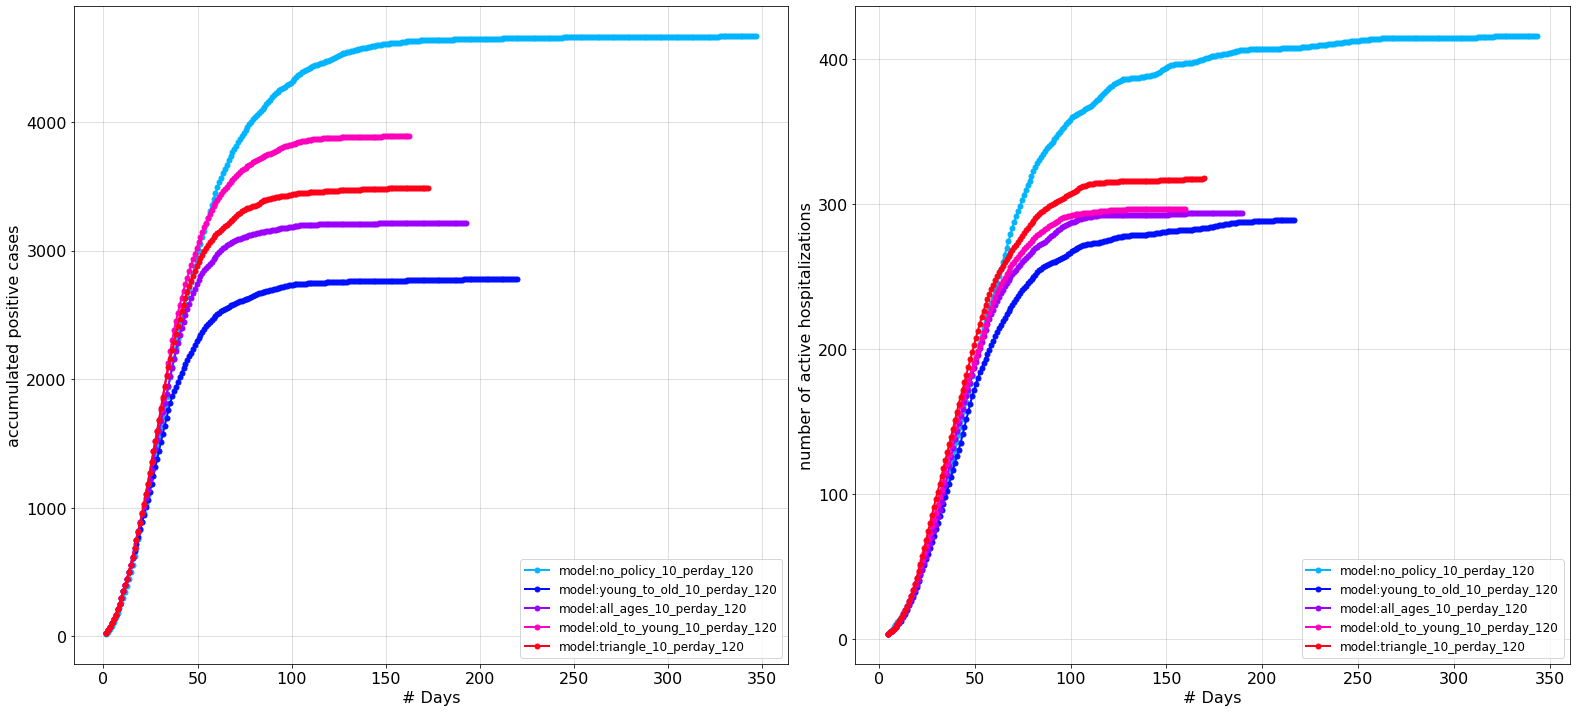

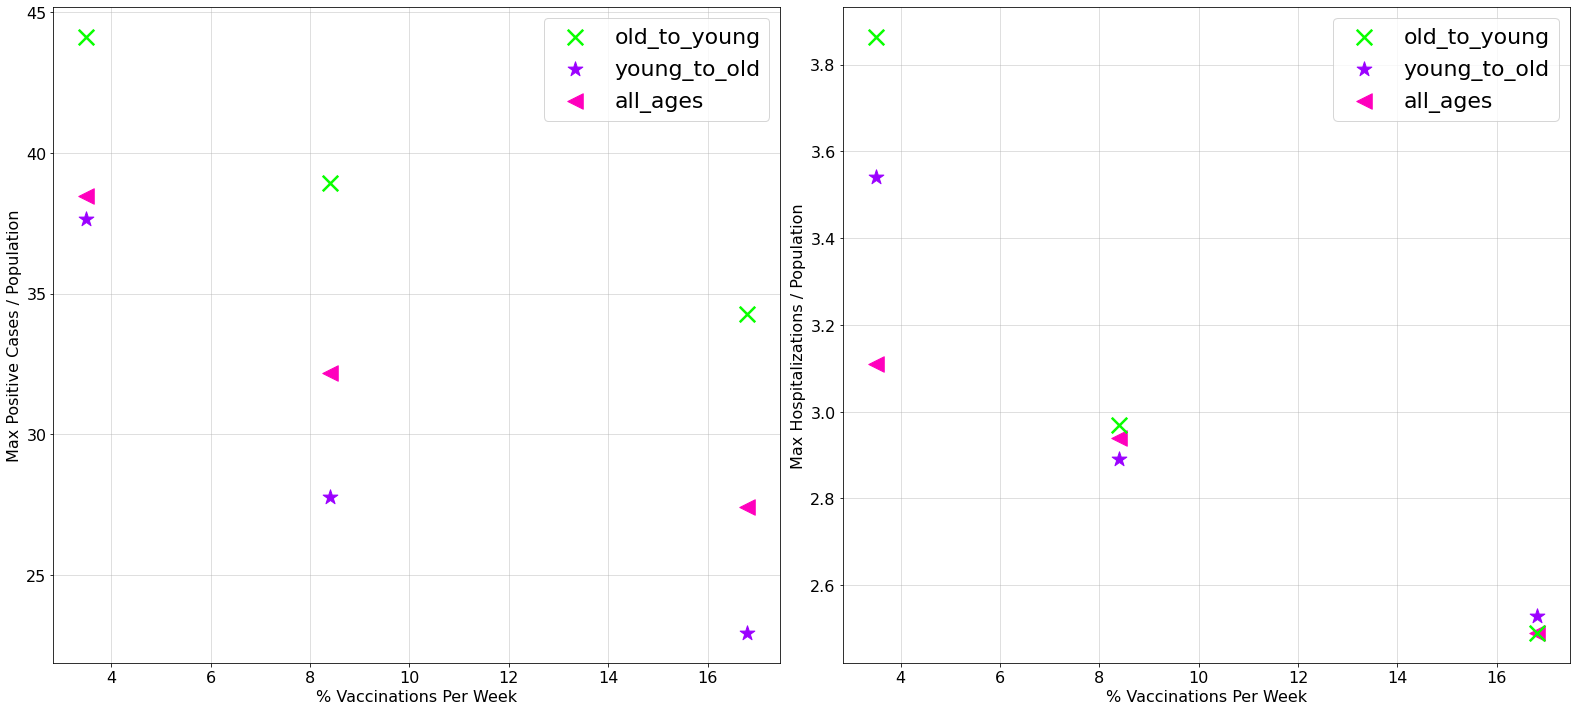

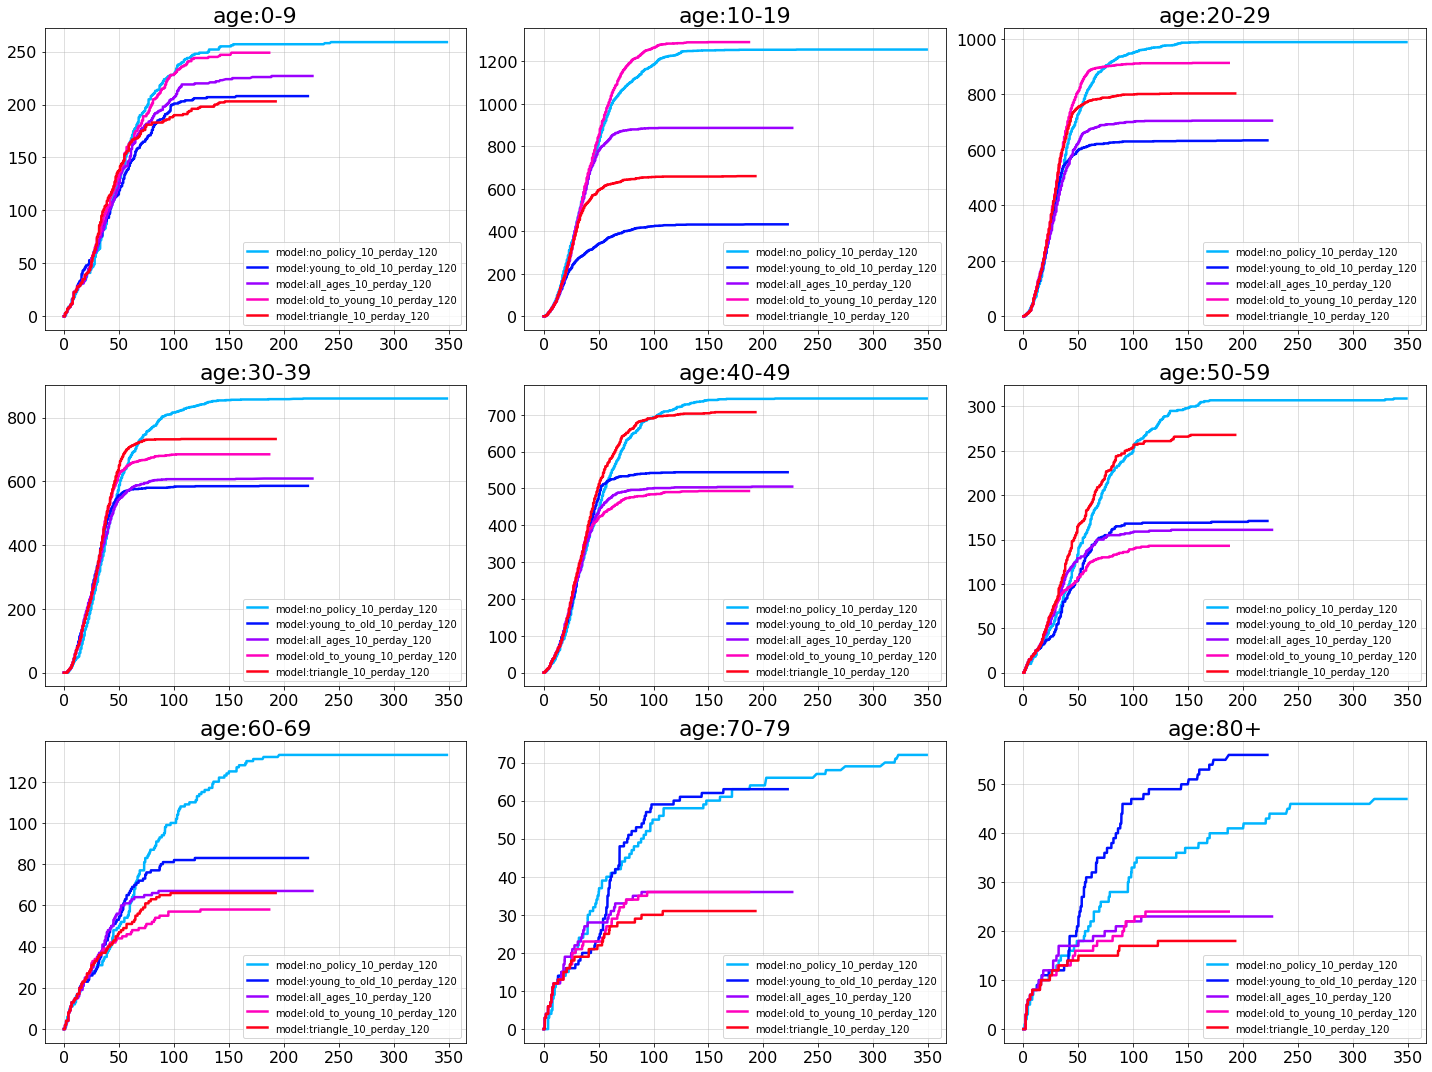

In [373]:
plt.rcParams["figure.figsize"] = (15,5)
models = range(len(data['model']))
fig, ax = plt.subplots(1, 2, figsize=(22, 10))
fig1, ax1 = plt.subplots(1, 2, figsize=(22, 10))
# plt.figure(figsize=(15, 10))
fig3, ax3 = plt.subplots(3, 3, figsize=(20, 15))
colors = get_cmap(10)
for m in models:
    model_temp = data['model'][m]
#     print(f"model name:{model_names[m]}")
#     print(f"alpha:{np.unique(model_temp.alpha)}")
    model_temp.numPositive[-1] /model_temp.numR[-1]
    x_k = []
    y_m = []
    N = model_temp.X.size
#     for num, key in enumerate(model_temp.nodeGroupData.keys()):
#         num_nodes = model_temp.nodeGroupData[key]['nodes'].size
#         per_pop = num_nodes/N
#         mean_age = np.mean(model_temp.nodeGroupData[key]['numPositive']/(model_temp.numPositive+1e-5))
#         x_k.append(key)
#         y_m.append((mean_age/per_pop).astype(float))
#     model_impact_factors_dict = {x: y for x,y in zip(x_k, y_m)}
#     ax2.bar(x_k,y_m, color=colors[m], alpha=0.3, label=f"model:{model_names[m]} impact factors")
    
#     plt.legend()
#     diff_impact_factors = np.array(list(real_factor_dict.values())) / np.array(list(model_impact_factors_dict.values()))
#     plt.figure()
#     plt.plot(real_factor_dict.keys(), diff_impact_factors, marker='*', color='m')
#     plt.plot([0, 8], [1, 1], color='k')
#     plt.ylabel("real / model impact factor")
#     plt.grid()
    accum_pos_per_day, days = get_data_per_day(model_temp.numPositive, model_temp.tseries)
    accum_rec_per_day, days = get_data_per_day(model_temp.numR, model_temp.tseries)
    active_hosp_per_day, _ = get_data_per_day(model_temp.numH, model_temp.tseries)
    active_pos_per_day, _ = get_data_per_day(model_temp.numI_sym + model_temp.numH, model_temp.tseries)
    accum_death_per_day, _ = get_data_per_day(model_temp.numF, model_temp.tseries)
    accum_hosp_per_day, _ = get_data_per_day(model_temp.numH_total, model_temp.tseries)
    max_hosp = np.max(accum_hosp_per_day)
    max_pos = np.max(accum_pos_per_day)
    if "120" in model_names[m]:
        ax[0].plot(moving_average(days, 4), moving_average(accum_pos_per_day, 4), label=f"model:{model_names[m]}", linewidth=2, color=colors[m], marker='.')
    #     ax[0].plot(days, accum_rec_per_day, label=f"model:{model_names[m]} - recoveries", linewidth=1, linestyle='--', color=colors[m])
        ax[1].plot(moving_average(days, 10), moving_average(accum_hosp_per_day, 10), label=f"model:{model_names[m]}", linewidth=2, color=colors[m], marker='.')

    #     ax[1].plot(moving_average(days, 10), moving_average(active_hosp_per_day, 10), label=f"model:{model_names[m]}", linewidth=2, color=colors[m], marker='.')
#             ax[2].plot(moving_average(days, 4), moving_average(active_pos_per_day, 4), label=f"model:{model_names[m]}", linewidth=2, color=colors[m], marker='.')
    if "young_to_old" in model_names[m] or "old_to_young" in model_names[m] or "all_ages" in model_names[m]:
        if "young_to_old" in model_names[m]:
            use_color = colors[7]
            use_marker = '*'
        if "old_to_young" in model_names[m]:
            use_color = colors[3]
            use_marker = 'x'
        if "triangle" in model_names[m]:
            use_color = colors[2]
            use_marker = 'o'
        if "all_ages" in model_names[m]:
            use_color = colors[8]
            use_marker = '<'
        ax1[0].scatter(100*mean_vacc_per_day[m]*7/N, 100 * max_pos/N, color=use_color, marker=use_marker, s=240)
        ax1[1].scatter(100*mean_vacc_per_day[m]*7/N, 100 * max_hosp/N, color=use_color, marker=use_marker, s=240)

#     ax[0].plot(model_temp.tseries, model_temp.numPositive, label=f"model:{model_names[m]}", linewidth=2, color=colors[m])
#     ax[1].plot(moving_average(model_temp.tseries, 30), moving_average(model_temp.numH, 30), label=f"model:{model_names[m]}", linewidth=2, color=colors[m])
#     ax[2].plot(moving_average(model_temp.tseries, 50), moving_average(model_temp.numI_sym + model_temp.numH, 50), label=f"model:{model_names[m]}", linewidth=2, color=colors[m])
#     ax1.plot(moving_average(model_temp.tseries, 4), moving_average(model_temp.numF, 4), label=f"model:{model_names[m]}", linewidth=2, color=colors[m])
    total_active_cases_to_israel = accum_pos_per_day.max()* 9.2e6/N
#         print(f"model:{model_names[m]} , max cases:{total_active_cases_to_israel}")

    if "120" in model_names[m]:
        for num, key in enumerate(model_temp.nodeGroupData.keys()):
            num_nodes = model_temp.nodeGroupData[key]['nodes'].size
            num_positive = model_temp.nodeGroupData[key]['numPositive']
            num_positive_norm = num_positive/np.max(num_positive)
            per_pop = num_nodes/N
            ax3[num//3, num%3].plot(model_temp.tseries, num_positive, label=f"model:{model_names[m]}", color=colors[m])
            if "triangle" in model_names[m]:
                ax3[num//3, num%3].legend(loc="lower right")
                ax3[num//3, num%3].grid()
                ax3[num//3, num%3].set_title(f"age:{key}")
#                 ax3[num//3, num%3].set_xlim([10, 30])
#                 ax3[num//3, num%3].set_ylim([0, 450])
ax[1].set_ylabel("number of active hospitalizations")
# ax[2].set_ylabel("number of active positive")
ax[0].set_ylabel("accumulated positive cases")
#     ax.plot(model_temp.tseries, model_temp.numS + model_temp.numQ_S, label=f"model:{model_names[m]} R")
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
ax[0].set_xlabel("# Days")
ax[1].set_xlabel("# Days")

# ax[2].legend(fontsize=12)
ax[0].grid()
ax[1].grid()
# ax[2].grid()
plt.savefig("simulation_results_per_age_10_days.png", facecolor='white', dpi=300)
ax1[0].grid()
ax1[1].grid()


ax1[0].scatter([], [], color=colors[3], marker='x', s=240, label='old_to_young')
ax1[1].scatter([], [], color=colors[3], marker='x', s=240, label='old_to_young')

ax1[0].scatter([], [], color=colors[7], marker='*', s=240, label='young_to_old')
ax1[1].scatter([], [], color=colors[7], marker='*', s=240, label='young_to_old')

# ax1[0].scatter([], [], color=colors[2], marker='o', s=240, label='triangle')
# ax1[1].scatter([], [], color=colors[2], marker='o', s=240, label='triangle')

ax1[0].scatter([], [], color=colors[8], marker='<', s=240, label='all_ages')
ax1[1].scatter([], [], color=colors[8], marker='<', s=240, label='all_ages')
ax1[0].set_xlabel("% Vaccinations Per Week")
ax1[1].set_xlabel("% Vaccinations Per Week")

ax1[0].set_ylabel("Max Positive Cases / Population")
ax1[1].set_ylabel("Max Hospitalizations / Population")


ax1[0].legend(fontsize=22)
ax1[1].legend(fontsize=22)

In [109]:
# colors = get_cmap(10)

# for model_temp in data['model']:
#     for num, key in enumerate(model_temp.nodeGroupData.keys()):
#         n_population = model_temp.X.size
#         n_group = len(model_temp.nodeGroupData[key]['nodes'])
#         num_positive_per_group = model_temp.nodeGroupData[key]['numPositive']
#         num_positive = model_temp.numPositive
#         num_positive, t = get_data_per_day(num_positive, model_temp.tseries)
#         num_positive_per_group, _ = get_data_per_day(num_positive_per_group, model_temp.tseries)
#         per_positive_to_total_positive = num_positive_per_group / (1e-5 + num_positive)
#         n_vaccinated = np.zeros_like(num_positive)
#         n_vaccinated[15:len(model_temp.numV[1:])+15] = model_temp.numV[1:]
#         n_vaccinated[len(model_temp.numV[1:])+15:] = model_temp.numV[-1]
#         n_not_vaccinated = n_population - n_vaccinated
#         per_population_corrected = n_group / (n_not_vaccinated+1e-5)
#         per_population = n_group / n_population
#         plt.figure()
#         plt.plot(t, per_positive_to_total_positive, label=f"age:{key} pos", color=colors[num], marker='x')
#         plt.plot(t, per_population_corrected, label=f"age:{key}, not vaccinated", color=colors[num], linestyle='--', marker='.')
#         plt.plot(t, np.zeros_like(t) + per_population, label=f"age:{key}, total", color=colors[num], linestyle='-.')

# #     nodes = model_temp.nodeGroupData[key]['nodes']
# #     for n in nodes:
# #         neighbors = model_temp.G.neighbors(n)
        
# #     num_positive = model_temp.nodeGroupData[key]['numPositive']
# #     num_positive_norm = num_positive/np.max(num_positive)
# #     per_pop = num_nodes/N
#         plt.grid()
#         plt.legend()
# # plt.xlim([15, 180])

In [ ]:
# self.S = 1
# self.E = 2
# self.I_pre = 3
# self.I_sym = 4
# self.I_asym = 5
# self.H = 6
# self.R = 7
# self.F = 8
# self.Q_S = 11
# self.Q_E = 12
# self.Q_pre = 13
# self.Q_sym = 14
# self.Q_asym = 15
# self.Q_R = 17

In [186]:
set(model_temp.G.neighbors(1100))

{971, 1022, 1099}

In [190]:
model_temp.X[list(model_temp.G.neighbors(150))]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])